# 0. Install and Import dependencies

In [33]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [34]:
# Gym stuff
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from finta import TA

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

# Processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import quantstats as qs

In [35]:
SEED = 5756

# Specify parameters
stock_name = 'MCD'

# Window size for training
train_window_size = 10
train_start = '2023-01-01'
train_end = '2023-09-01'

test_window_size = 10
learn_iteration = 100000

# Model parameters
model_name = 'A2C'

# Indicator parameters
sma_period = 10

# 1. Get Data

In [36]:
import yfinance as yf

df = yf.Ticker(stock_name)
df = df.history(period="max")
df = df.loc[train_start:, ['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.shape)
df.head()

(328, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2023-01-03 00:00:00-05:00,256.237926,257.035243,252.329173,257.015778,2743800
2023-01-04 00:00:00-05:00,258.882707,259.174394,255.615694,257.074188,2584100
2023-01-05 00:00:00-05:00,257.433915,257.433915,254.147438,254.905853,1945600
2023-01-06 00:00:00-05:00,256.461588,262.421972,256.101831,262.013580,2855400
2023-01-09 00:00:00-05:00,262.460846,262.480312,259.388282,259.855011,2654600


In [37]:
TRAIN_ENV_FRAME_BOUND = (train_window_size, df[train_start:train_end].shape[0])
TEST_ENV_FRAME_BOUND = (df[train_start:train_end].shape[0] + test_window_size, df.shape[0])

# 2.1 Add Custom Indicators

## 2.1.3. Calculate SMA, RSI and OBV

In [38]:
df['SMA'] = TA.SMA(df, sma_period)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.1.4. Create New Environments

In [39]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [40]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

# 3. Build Environment and Train

In [41]:
env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=train_window_size)
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [42]:
from sb3_contrib import RecurrentPPO

if model_name == 'A2C':
    model = A2C('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'RecurrentPPO':
    model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'PPO':
    model = PPO('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'DQN':
    model = DQN('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)

# 4. Evaluation

In [43]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=test_window_size)
observation, info = env.reset()
while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 6.593890560744711, 'total_profit': 0.7391640006492661, 'position': <Positions.Long: 1>}


In [44]:
total_profit = round(info['total_profit'], 2)

# Report output
trade_strategy_output = f".\\reports\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{train_window_size}_ITER{learn_iteration}_trade_strategy.png"
report_output = f".\\reports\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{train_window_size}_ITER{learn_iteration}_reports.html"

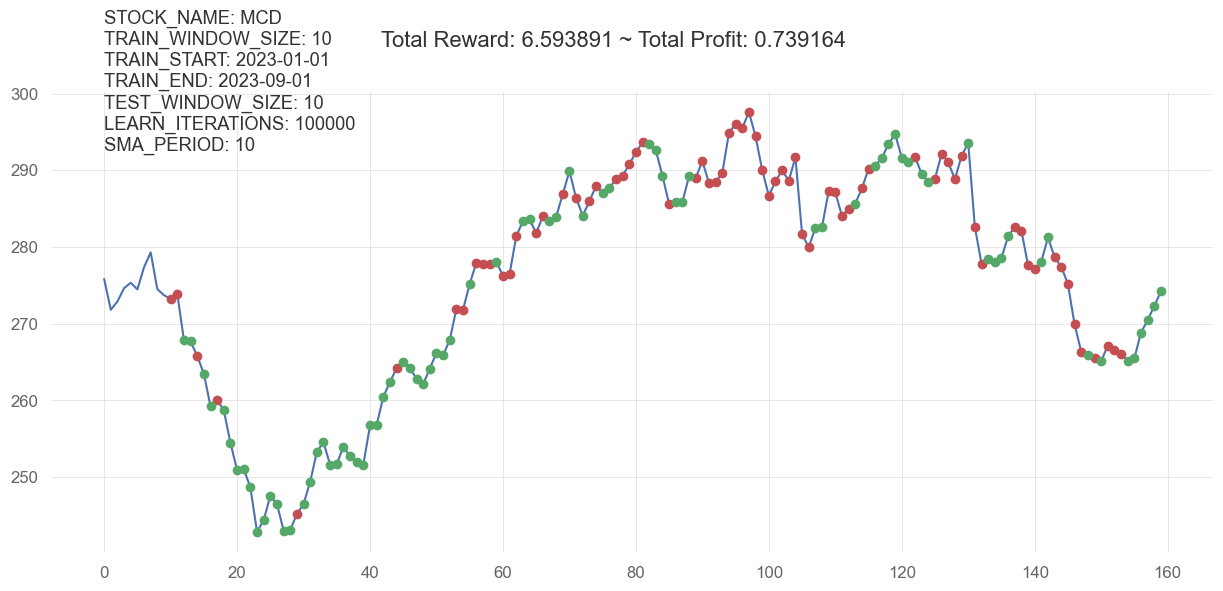

In [45]:
desc = f'STOCK_NAME: {stock_name}\nTRAIN_WINDOW_SIZE: {train_window_size}\nTRAIN_START: {train_start}\nTRAIN_END: {train_end}\nTEST_WINDOW_SIZE: {test_window_size}\nLEARN_ITERATIONS: {learn_iteration}\nSMA_PERIOD: {sma_period}'

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.text(0, env.prices.max() - 5, desc)
plt.savefig(trade_strategy_output)
plt.show()

# 5. QuantStats

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

                           Strategy
-------------------------  ----------
Start Period               2023-09-21
End Period                 2024-04-23
Risk-Free Rate             0.0%
Time in Market             17.0%

Cumulative Return          -26.08%
CAGR﹪                     -29.83%

Sharpe                     -3.04
Prob. Sharpe Ratio         0.51%
Smart Sharpe               -2.92
Sortino                    -3.38
Smart Sortino              -3.25
Sortino/√2                 -2.39
Smart Sortino/√2           -2.3
Omega                      0.23

Max Drawdown               -27.45%
Longest DD Days            212
Volatility (ann.)          16.48%
Calmar                     -1.09
Skew                       -1.91
Kurtosis                   20.4

Expected Daily %           -0.2%
Expected Monthly %         -3.71%
Expected Yearly %          -14.03%
Kelly Criterion            -70.03%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.91%
Expected Shortfall (cVaR)  -1.91%

Max Consecutiv

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-09-25,2024-04-11,2024-04-23,212,-27.449006,-26.910328


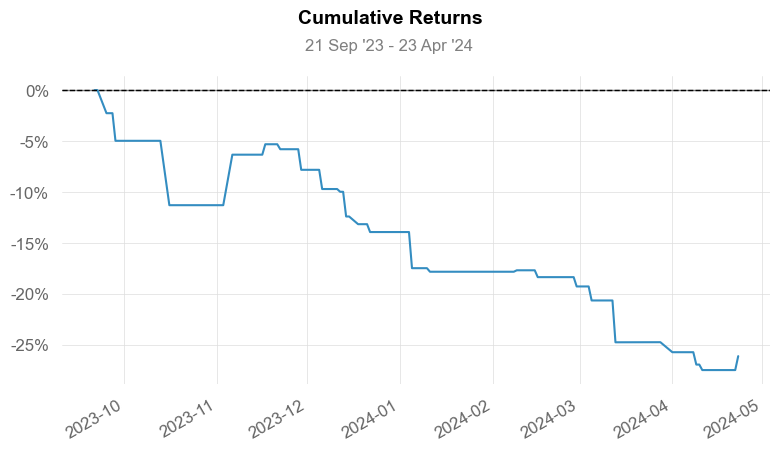

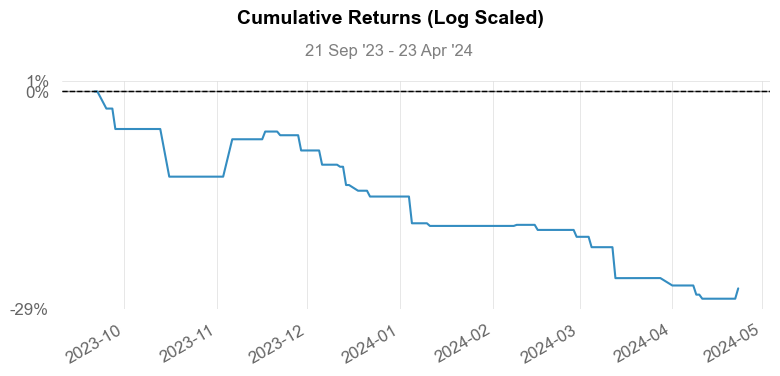

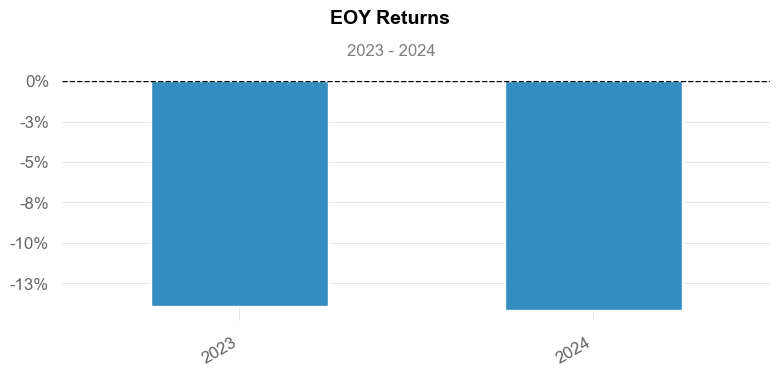

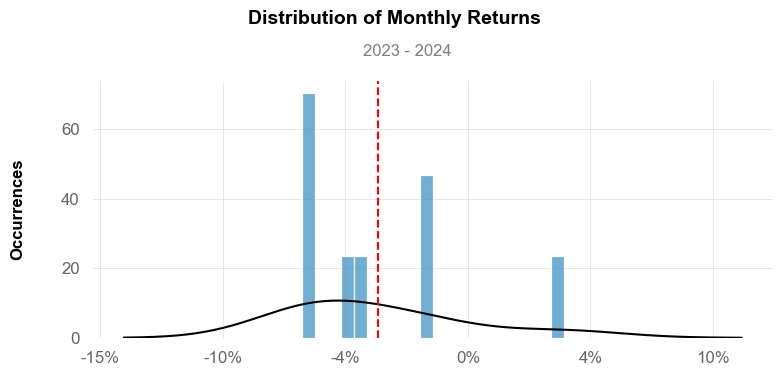

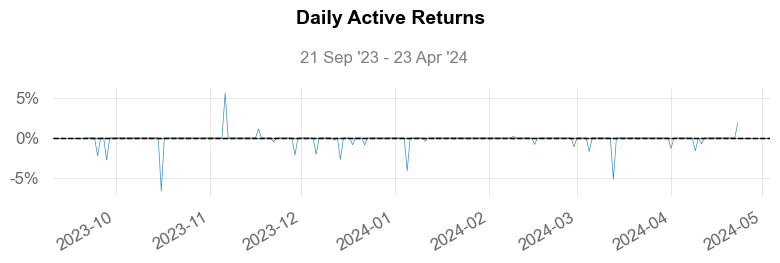

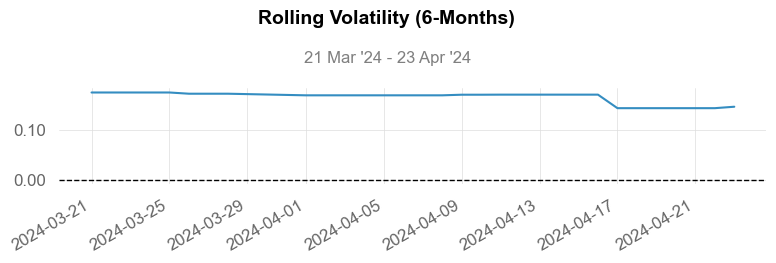

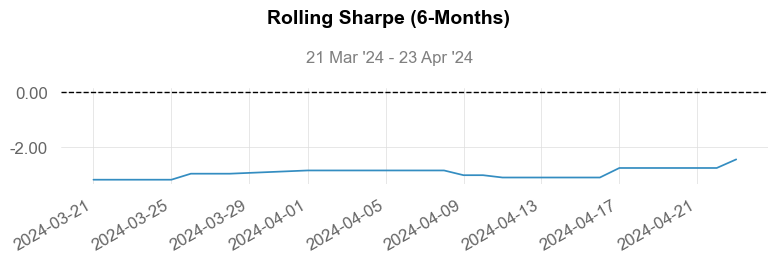

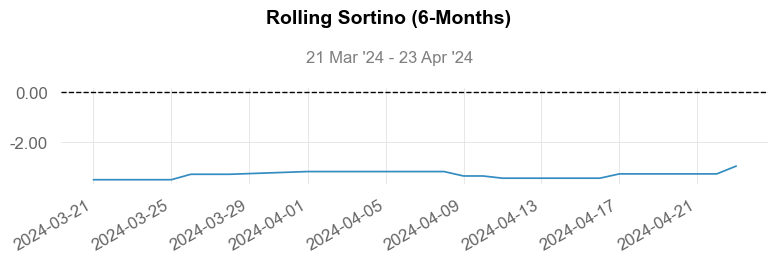

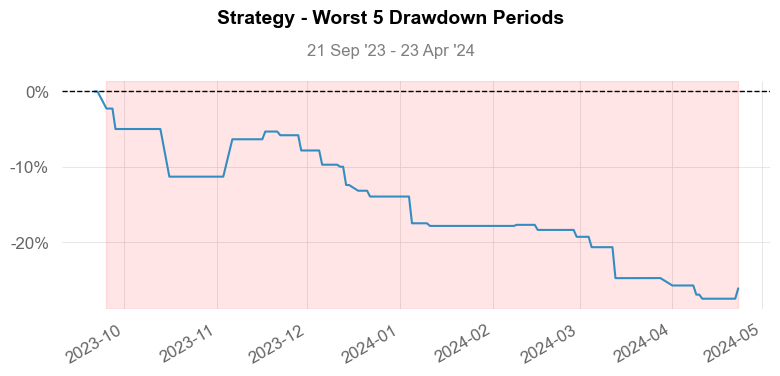

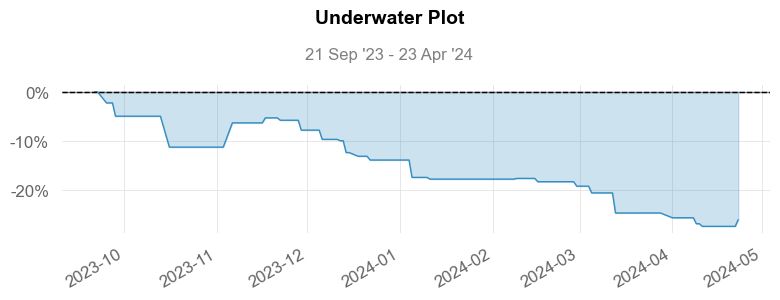

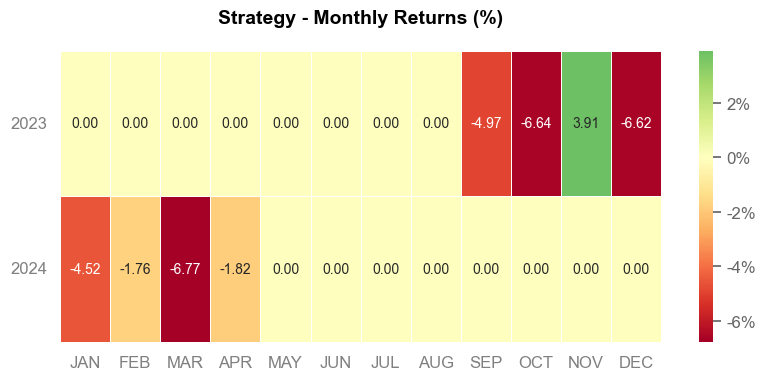

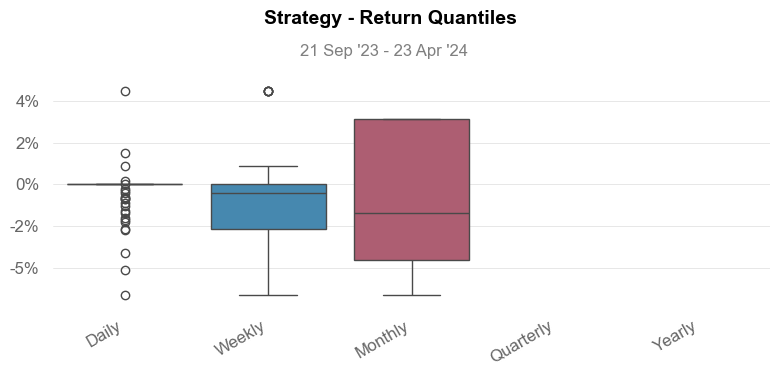

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

In [46]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output=report_output)

In [72]:
from typing import List
SEED = 5756
def analyze_stock(
    stock_name: str,
    window_size: int,
    train_start: str,
    train_end: str,
    learn_iteration: str,
    model_name: str
) -> None:
    print(f'Stock Name: {stock_name}\nTrain Window Size: {window_size}')
    print(f'Train Start: {train_start}\nTrain End: {train_end}')
    print(f'Test Window Size: {window_size}\nLearn Iteration: {learn_iteration}')
    print(f'Model Name: {model_name}')

    df = yf.Ticker(stock_name)
    df = df.history(period="max")
    df = df.loc['2020-01-01':, ['Open', 'High', 'Low', 'Close', 'Volume']]
    TRAIN_ENV_FRAME_BOUND = (window_size, df[train_start:train_end].shape[0])
    TEST_ENV_FRAME_BOUND = (df[train_start:train_end].shape[0] + window_size, df.shape[0])

    df['SMA'] = TA.SMA(df, 10)
    df['RSI'] = TA.RSI(df)
    df['OBV'] = TA.OBV(df)
    df.fillna(0, inplace=True)

    def add_signals(env):
        start = env.frame_bound[0] - env.window_size
        end = env.frame_bound[1]
        prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
        signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
        return prices, signal_features
    
    class MyCustomEnv(StocksEnv):
        _process_data = add_signals

    env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=window_size)
    env_maker = lambda: env2
    env = DummyVecEnv([env_maker])

    if model_name == 'A2C':
        model = A2C('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'RecurrentPPO':
        model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'PPO':
        model = PPO('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)
    elif model_name == 'DQN':
        model = DQN('MlpPolicy', env, verbose=0, seed=SEED) 
        model.learn(total_timesteps=learn_iteration)

    env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=window_size)
    observation, info = env.reset()
    while True: 
        observation = observation[np.newaxis, ...]
        action, _states = model.predict(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            print("info", info)
            break
    
    total_profit = round(info['total_profit'], 2)

    # Report output
    trade_strategy_output = f".\\{stock_name}\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{window_size}_ITER{learn_iteration}_trade_strategy.png"
    report_output = f".\\{stock_name}\\{stock_name}_{model_name}_PROFIT{total_profit}_WINSIZE{window_size}_ITER{learn_iteration}_reports.html"

    desc = f'STOCK_NAME: {stock_name}\nwindow_size: {window_size}\nTRAIN_START: {train_start}\nTRAIN_END: {train_end}\nwindow_size: {window_size}\nLEARN_ITERATIONS: {learn_iteration}\nSMA_PERIOD: 10'
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.text(0, env.prices.max() - 5, desc)
    plt.savefig(trade_strategy_output)

    qs.extend_pandas()

    net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
    returns = net_worth.pct_change().iloc[1:]

    qs.reports.html(returns, output=report_output)

Stock Name: MCD
Train Window Size: 10
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 10
Learn Iteration: 100
Model Name: A2C
info {'total_reward': -10.495410161131474, 'total_profit': 0.10629618551750811, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MCD
Train Window Size: 10
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 10
Learn Iteration: 100
Model Name: PPO
info {'total_reward': -9.76197763024257, 'total_profit': 0.11729995378262628, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MCD
Train Window Size: 10
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 10
Learn Iteration: 100
Model Name: DQN
info {'total_reward': 28.56887584842454, 'total_profit': 0.6489405035083058, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MCD
Train Window Size: 30
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 30
Learn Iteration: 100
Model Name: A2C
info {'total_reward': -28.64519349969038, 'total_profit': 0.30278620349721147, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MCD
Train Window Size: 30
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 30
Learn Iteration: 100
Model Name: PPO
info {'total_reward': -5.561072802573335, 'total_profit': 0.11478427341872745, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MCD
Train Window Size: 30
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 30
Learn Iteration: 100
Model Name: DQN
info {'total_reward': -18.3504258162001, 'total_profit': 0.730413695340258, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MCD
Train Window Size: 50
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 50
Learn Iteration: 100
Model Name: A2C
info {'total_reward': -2.0173715778932717, 'total_profit': 0.14734109369529988, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MCD
Train Window Size: 50
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 50
Learn Iteration: 100
Model Name: PPO
info {'total_reward': 33.868928647914885, 'total_profit': 0.14434463229842717, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MCD
Train Window Size: 50
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 50
Learn Iteration: 100
Model Name: DQN
info {'total_reward': 10.024042631330929, 'total_profit': 0.5733650255532097, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MRO
Train Window Size: 10
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 10
Learn Iteration: 100
Model Name: A2C
info {'total_reward': 8.395047426288347, 'total_profit': 0.16840080973723173, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MRO
Train Window Size: 10
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 10
Learn Iteration: 100
Model Name: PPO
info {'total_reward': 3.6888693688640934, 'total_profit': 0.1428314504829026, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MRO
Train Window Size: 10
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 10
Learn Iteration: 100
Model Name: DQN
info {'total_reward': -2.3152328568945038, 'total_profit': 0.7087640571416365, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MRO
Train Window Size: 30
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 30
Learn Iteration: 100
Model Name: A2C
info {'total_reward': 5.1705998181610475, 'total_profit': 0.15232927903190432, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MRO
Train Window Size: 30
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 30
Learn Iteration: 100
Model Name: PPO
info {'total_reward': 8.699850208030973, 'total_profit': 0.1715761992718387, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MRO
Train Window Size: 30
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 30
Learn Iteration: 100
Model Name: DQN
info {'total_reward': 0.6809247411024906, 'total_profit': 0.8600906263865116, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MRO
Train Window Size: 50
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 50
Learn Iteration: 100
Model Name: A2C
info {'total_reward': -2.9566972910662166, 'total_profit': 0.13192168655633926, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MRO
Train Window Size: 50
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 50
Learn Iteration: 100
Model Name: PPO
info {'total_reward': -0.0490120196441346, 'total_profit': 0.1408708945090231, 'position': <Positions.Long: 1>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

Stock Name: MRO
Train Window Size: 50
Train Start: 2021-01-01
Train End: 2022-12-31
Test Window Size: 50
Learn Iteration: 100
Model Name: DQN
info {'total_reward': -1.0949405415789215, 'total_profit': 0.7409194227733363, 'position': <Positions.Short: 0>}


c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

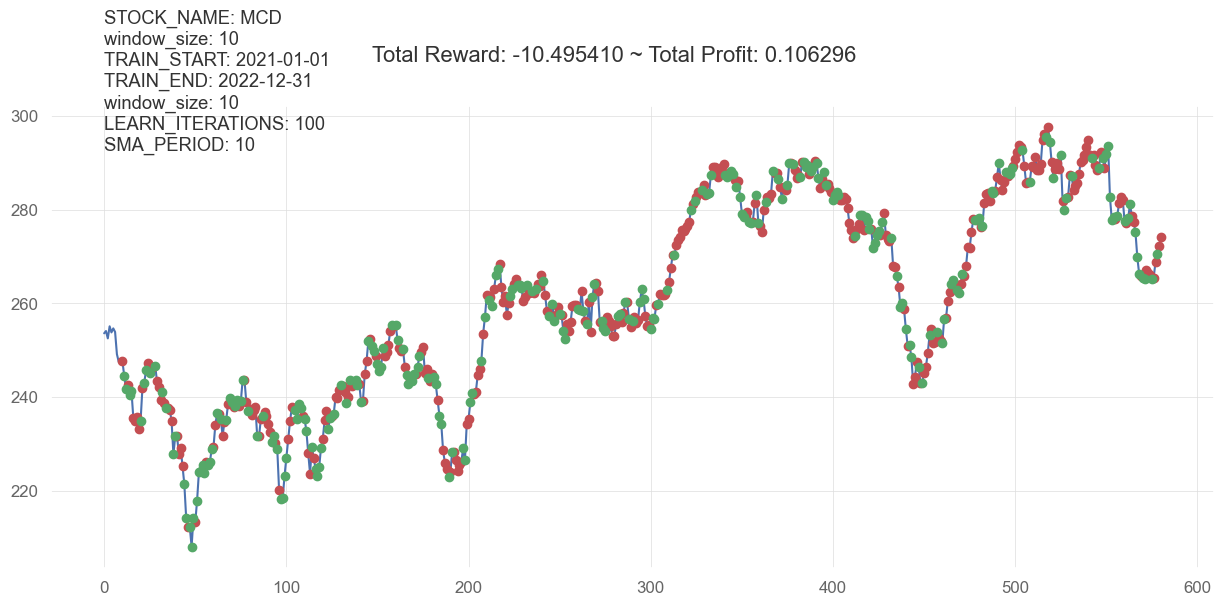

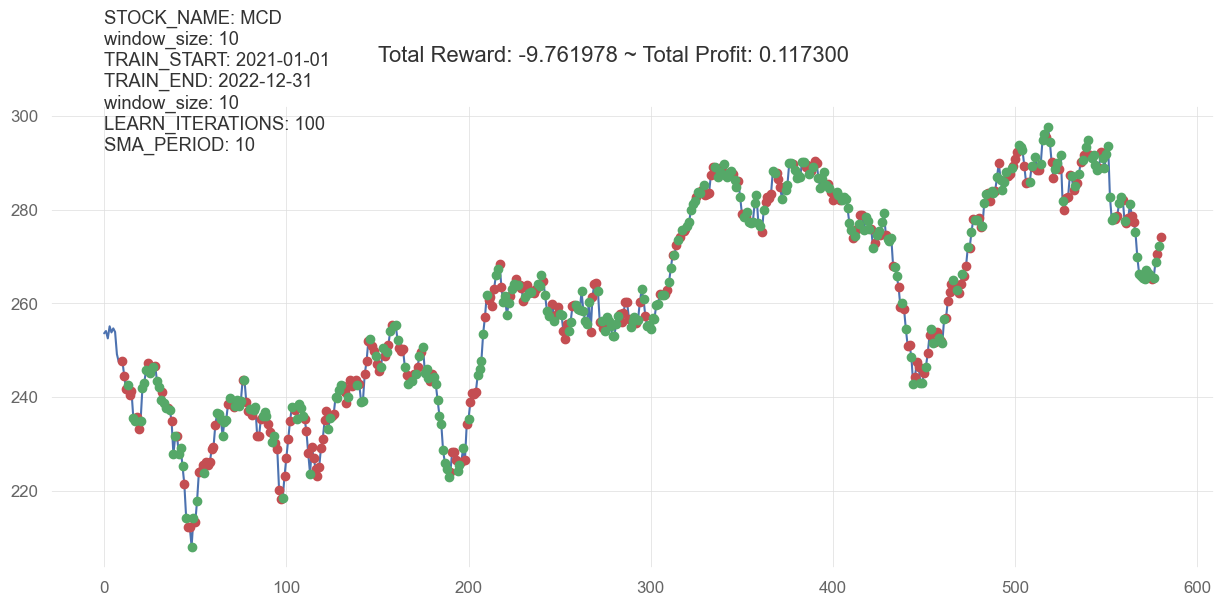

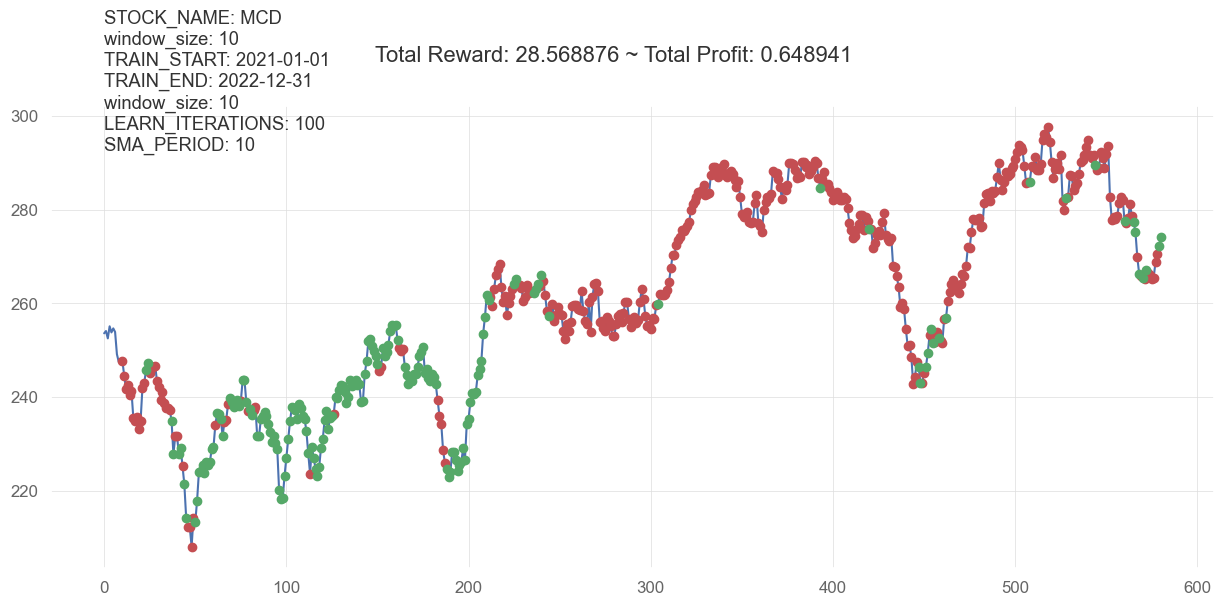

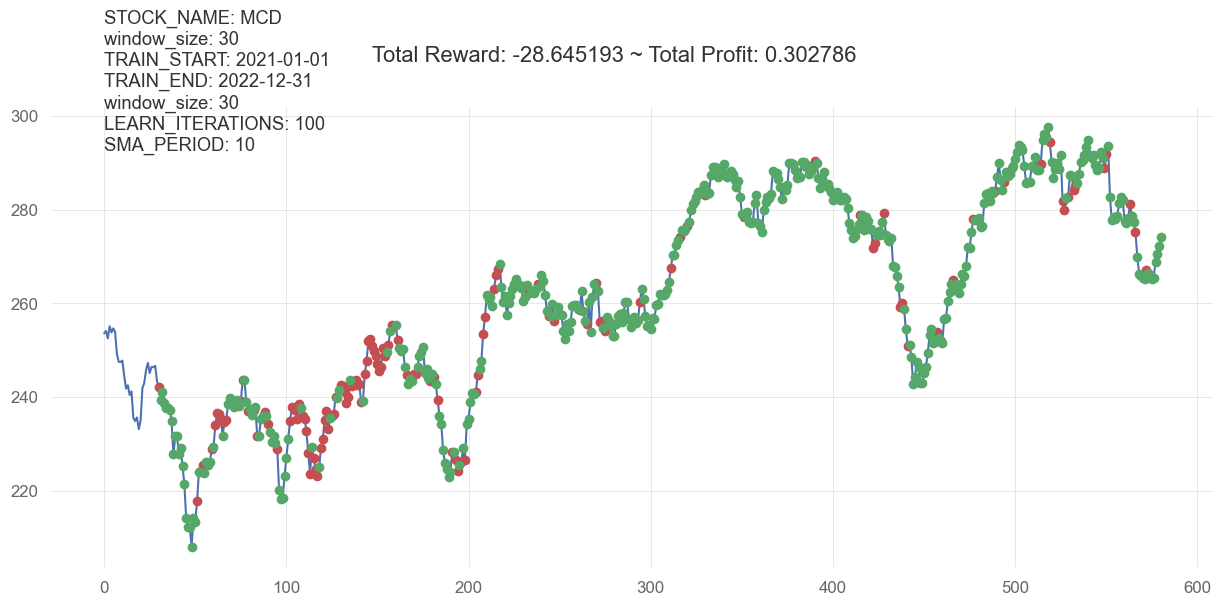

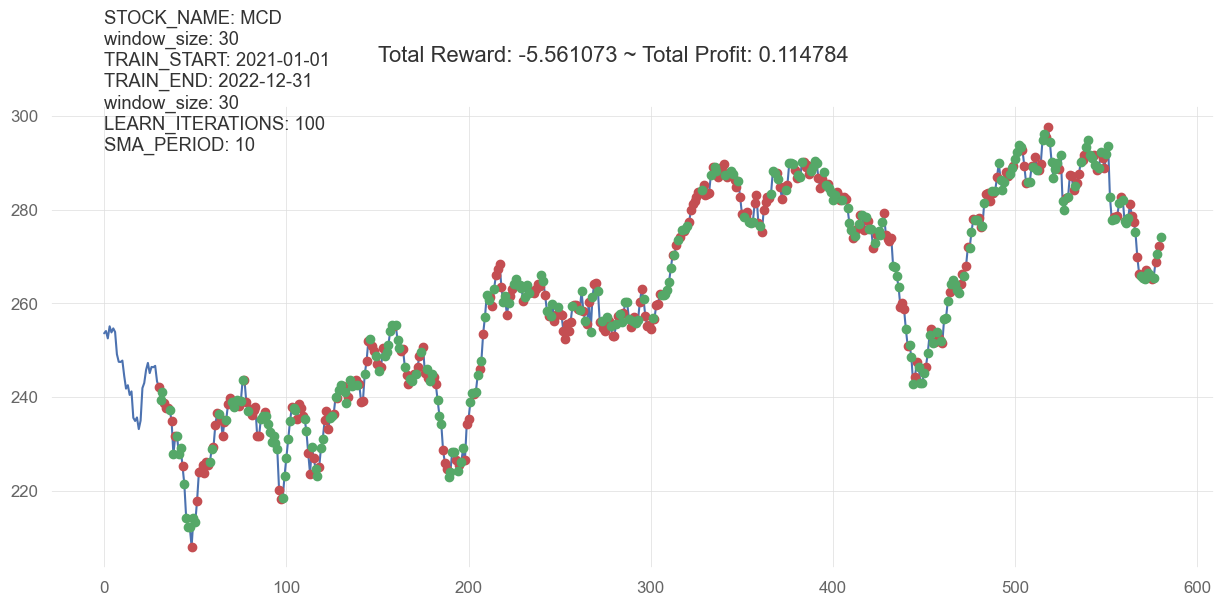

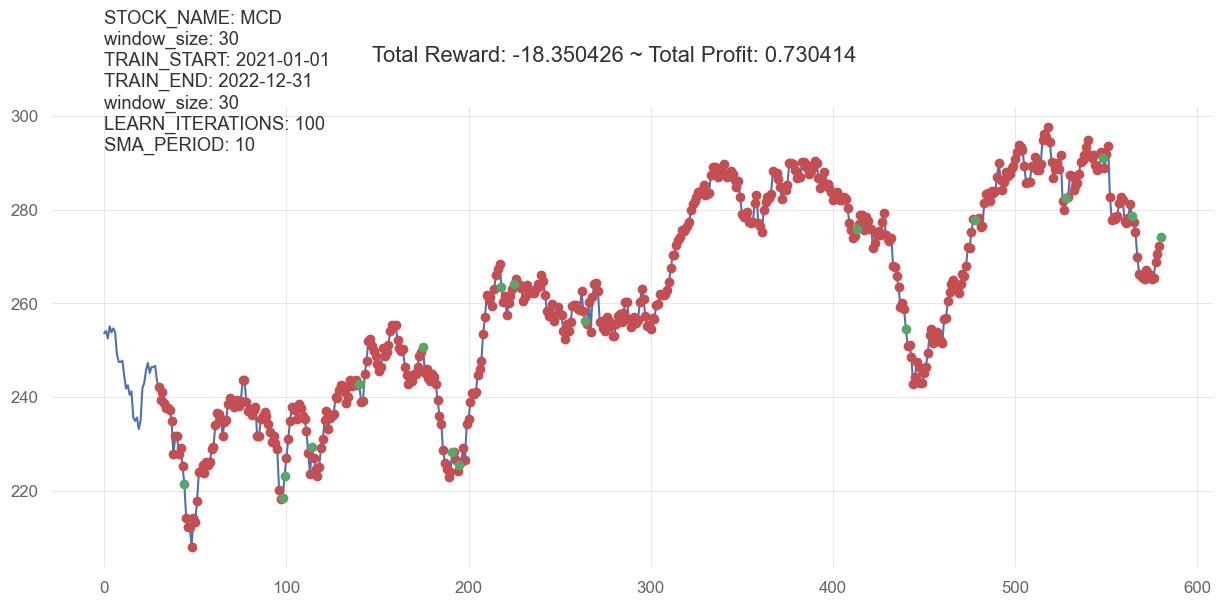

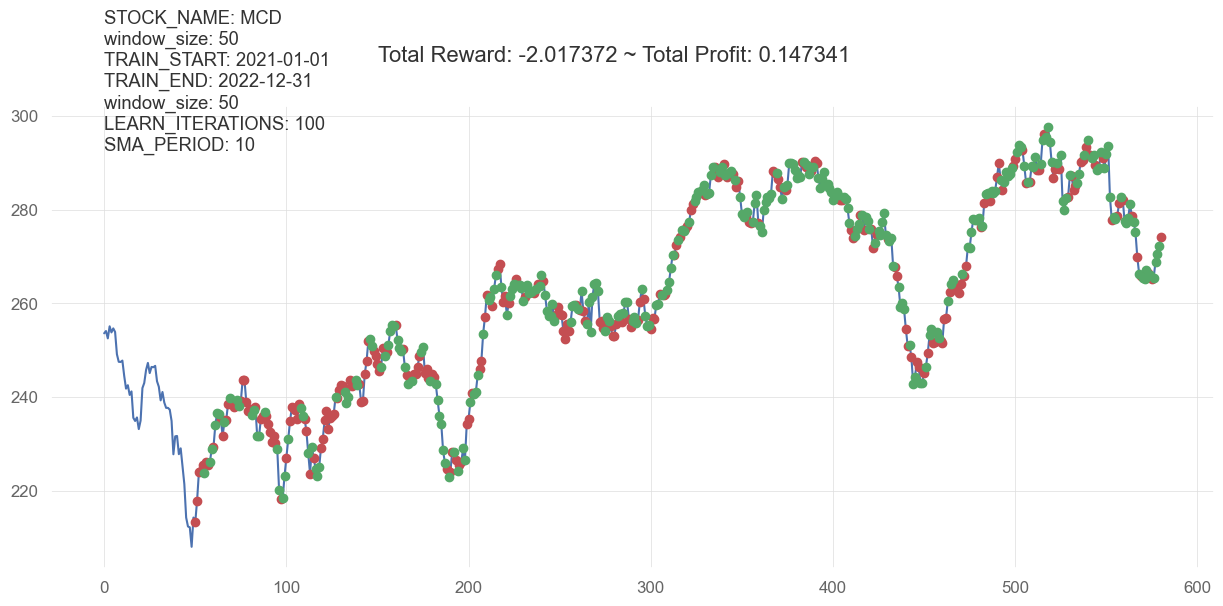

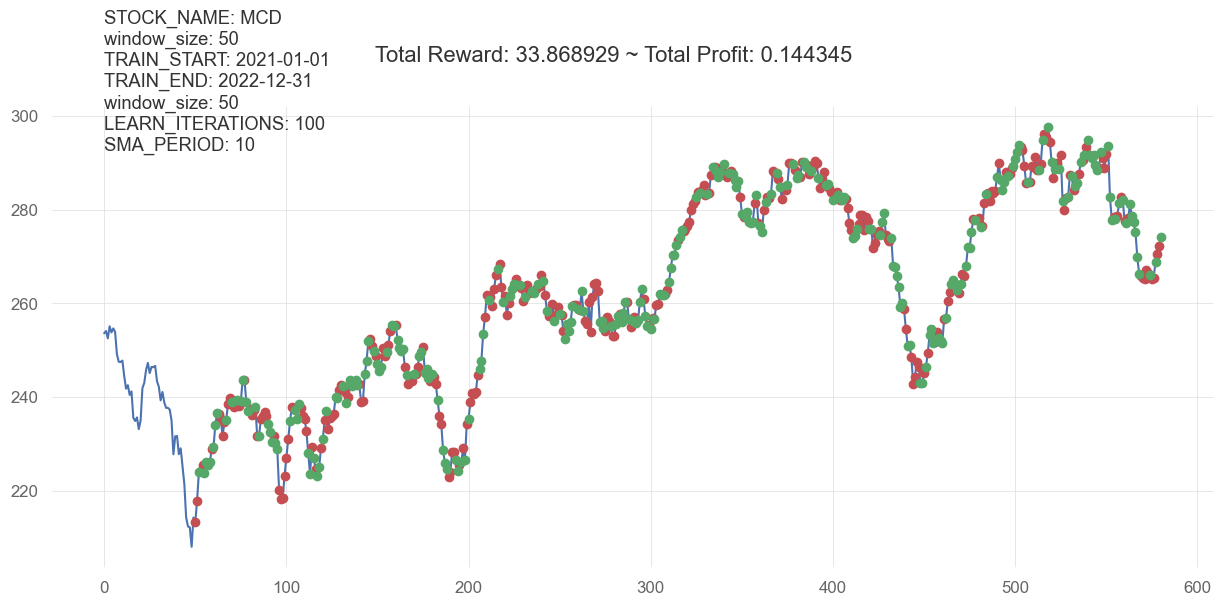

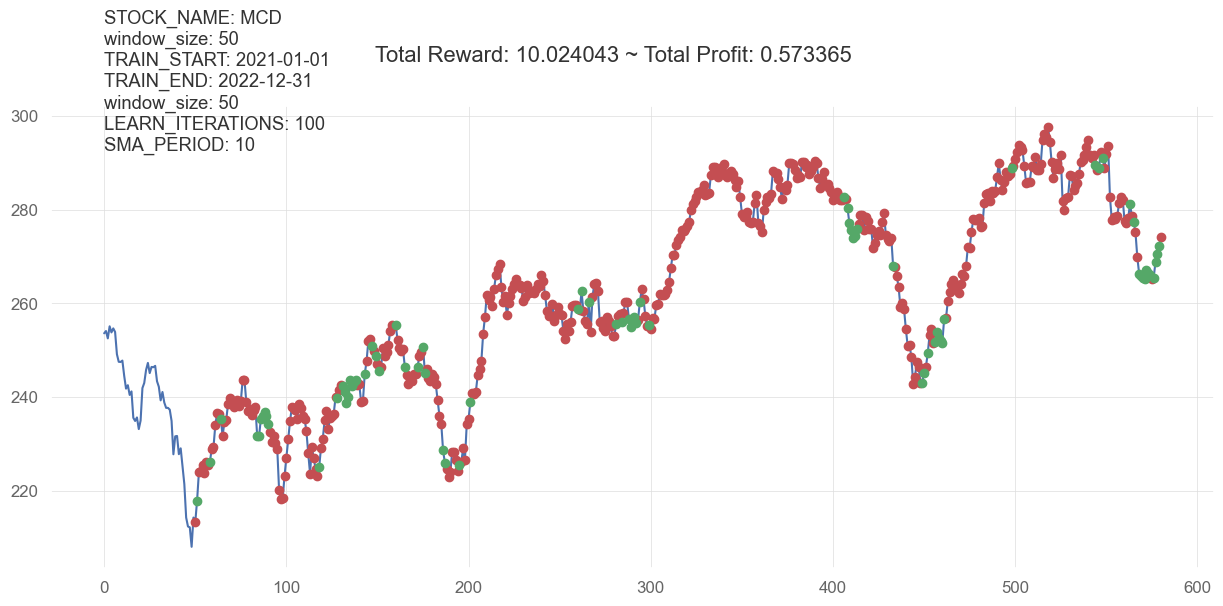

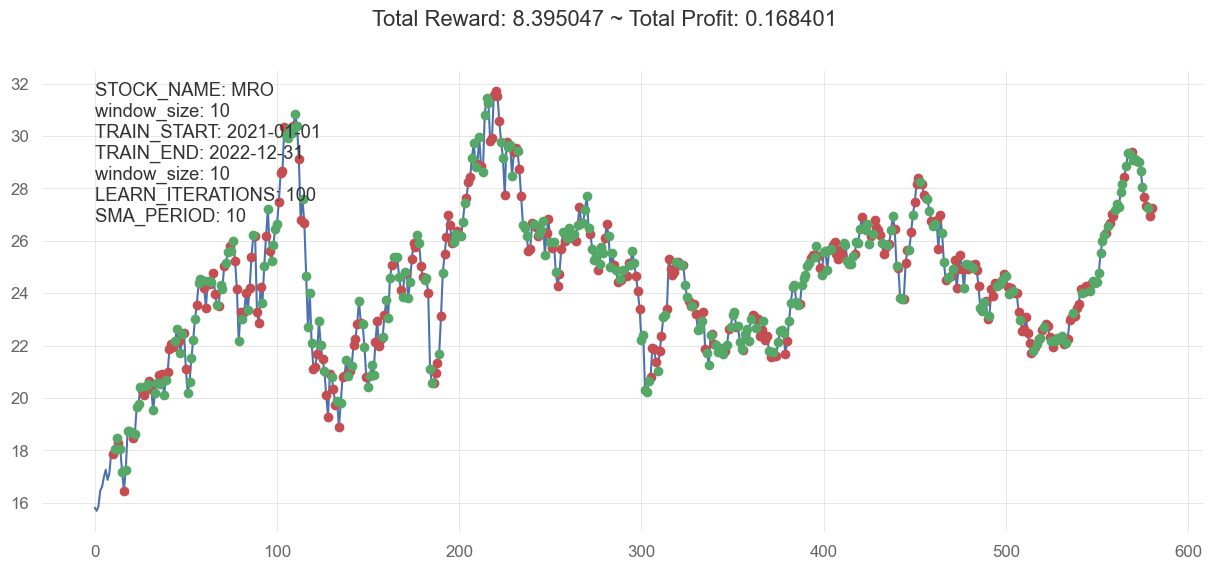

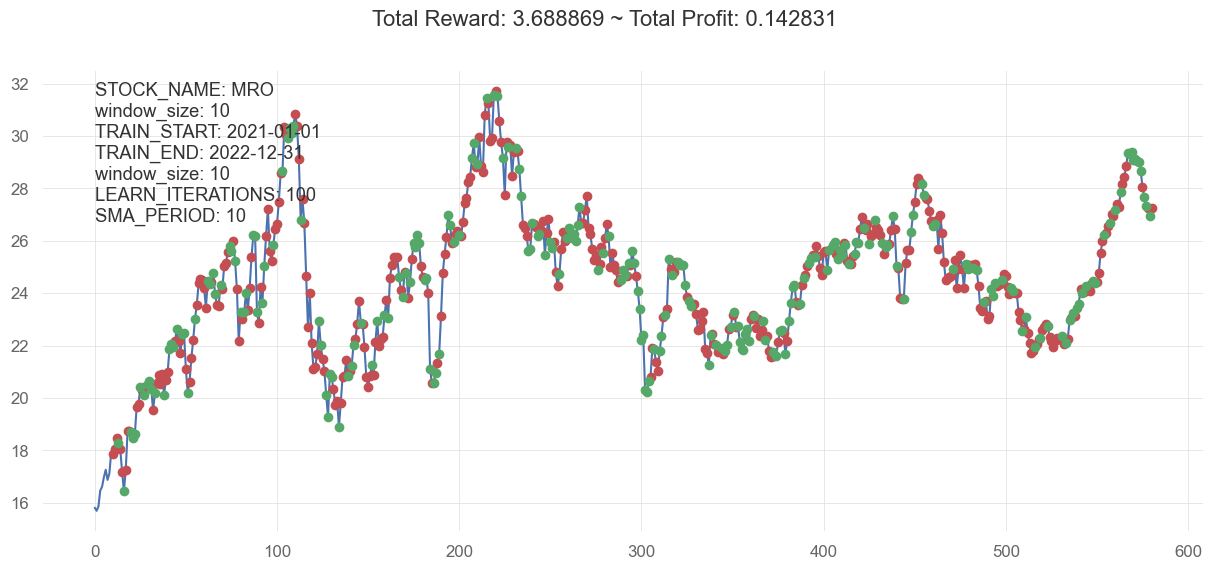

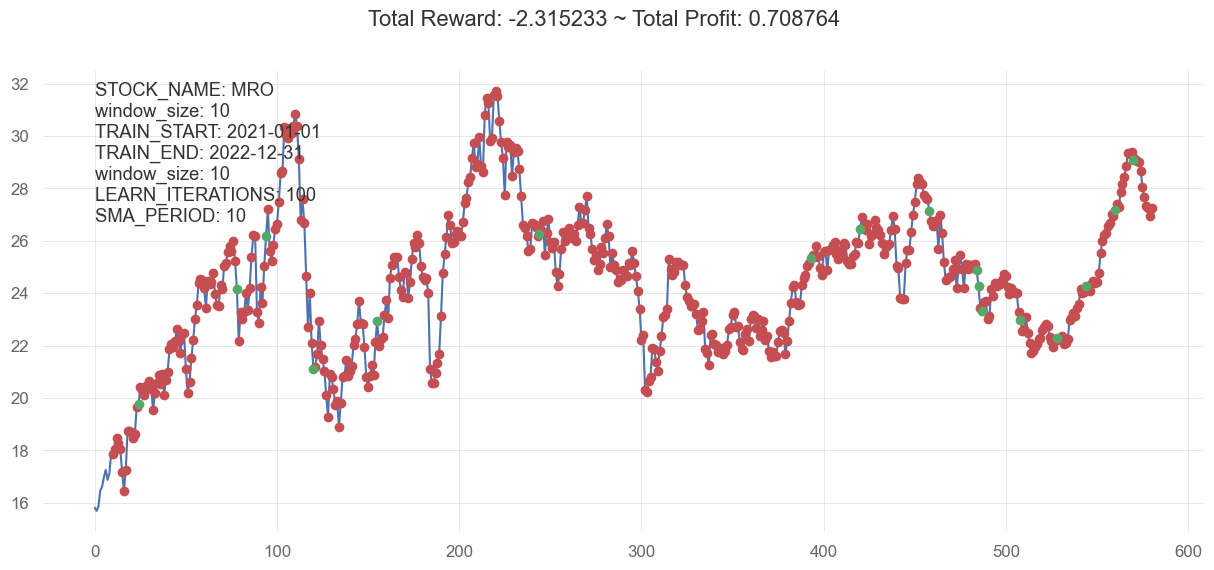

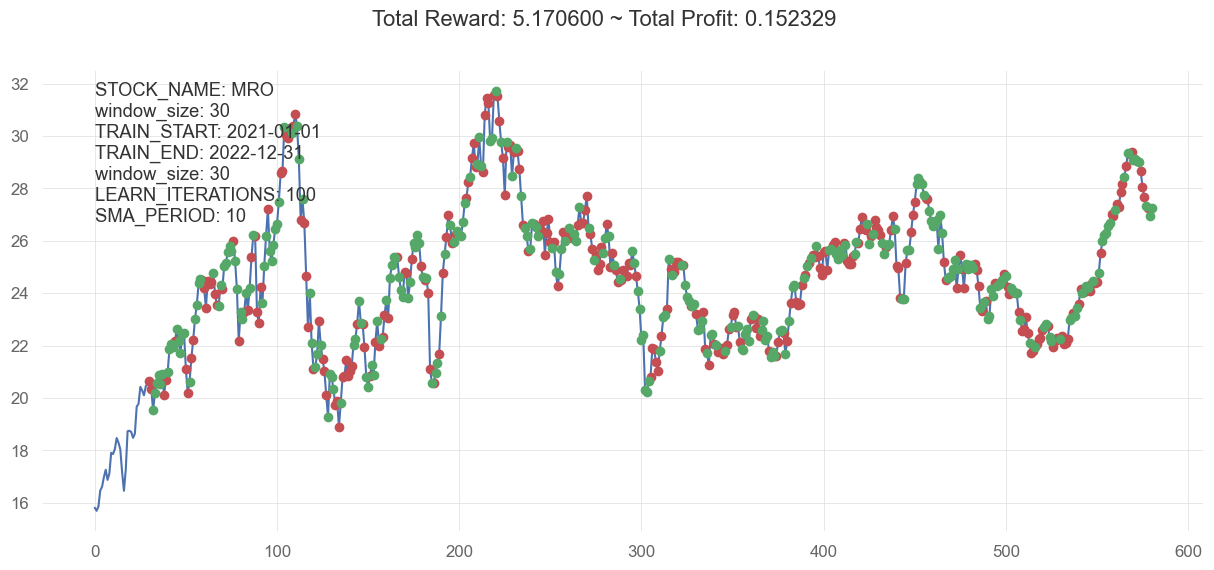

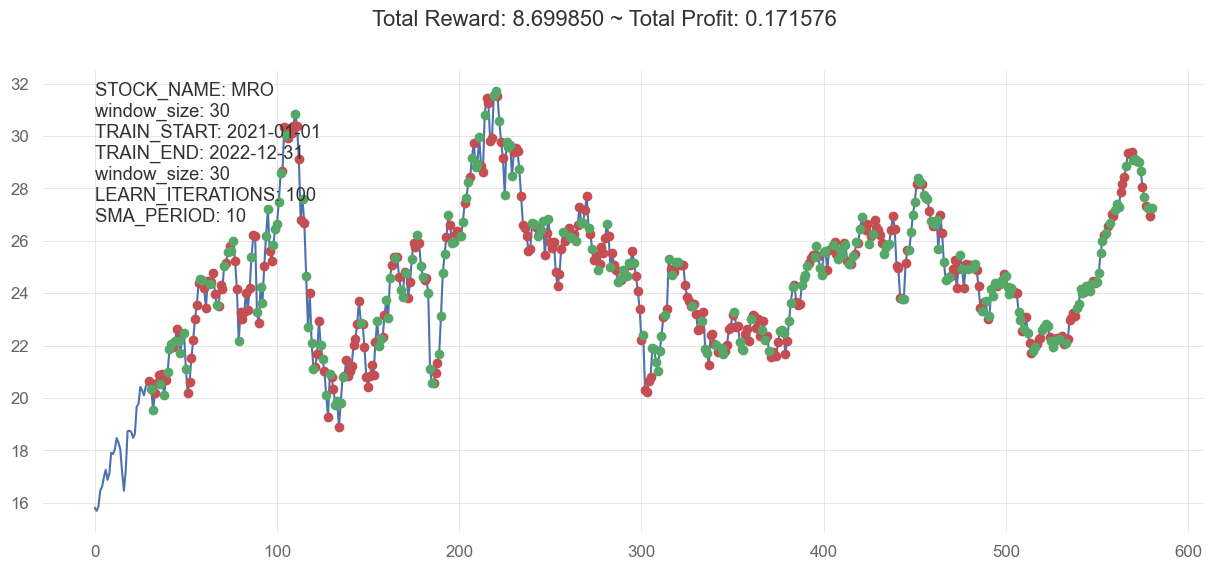

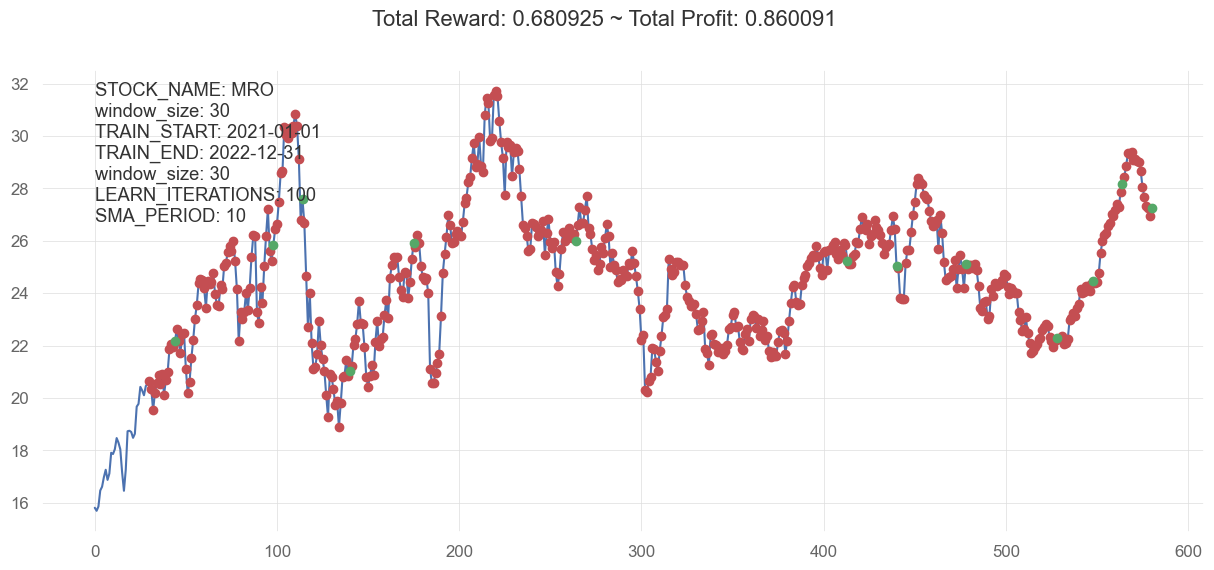

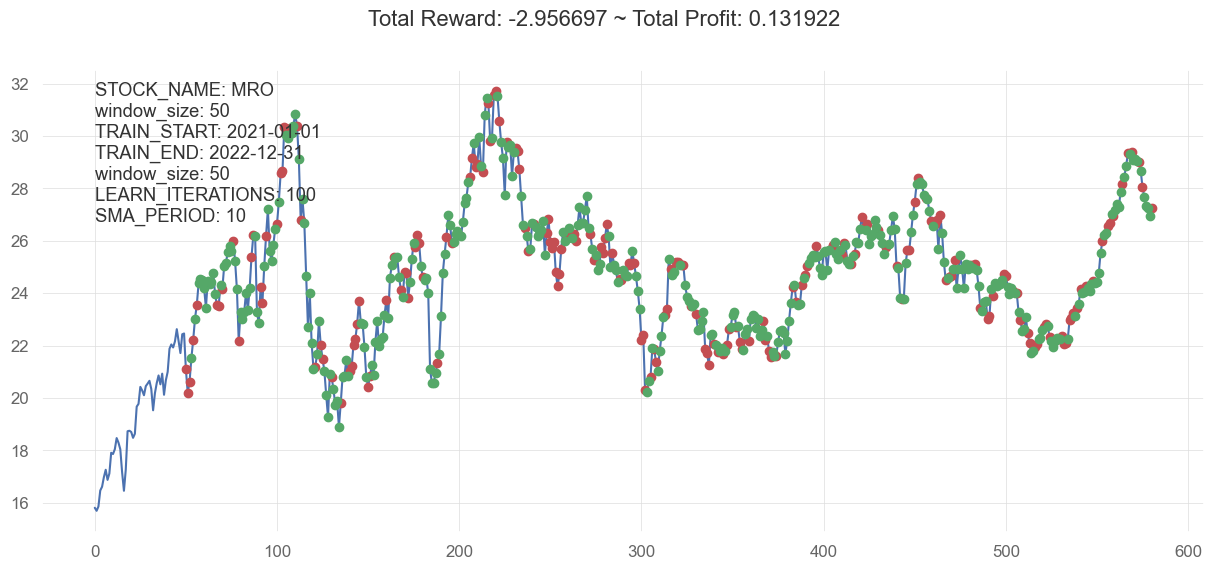

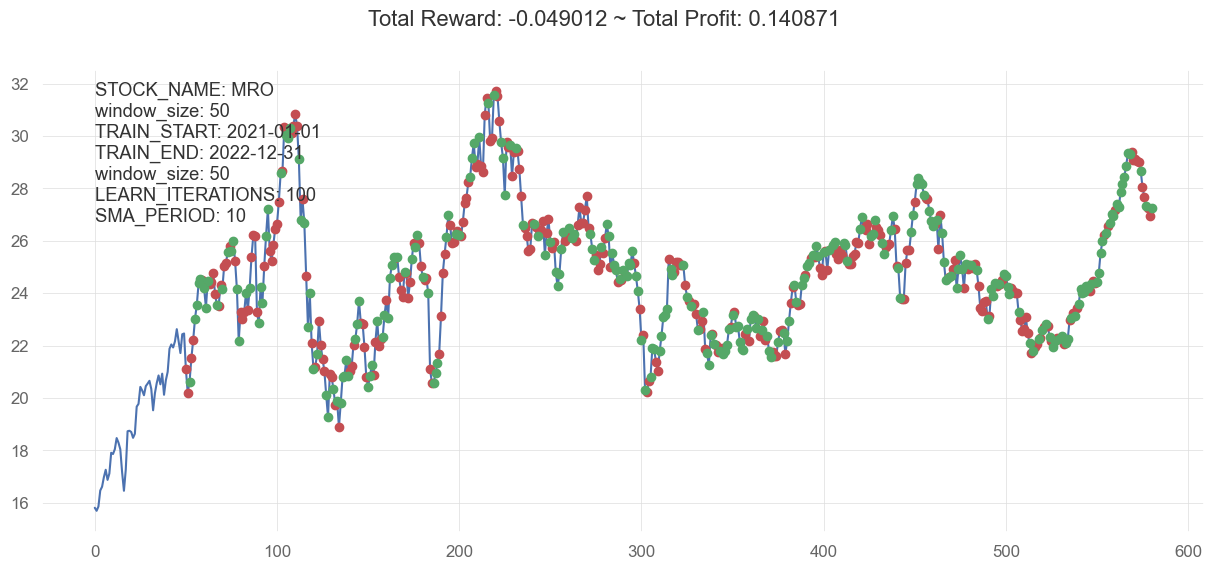

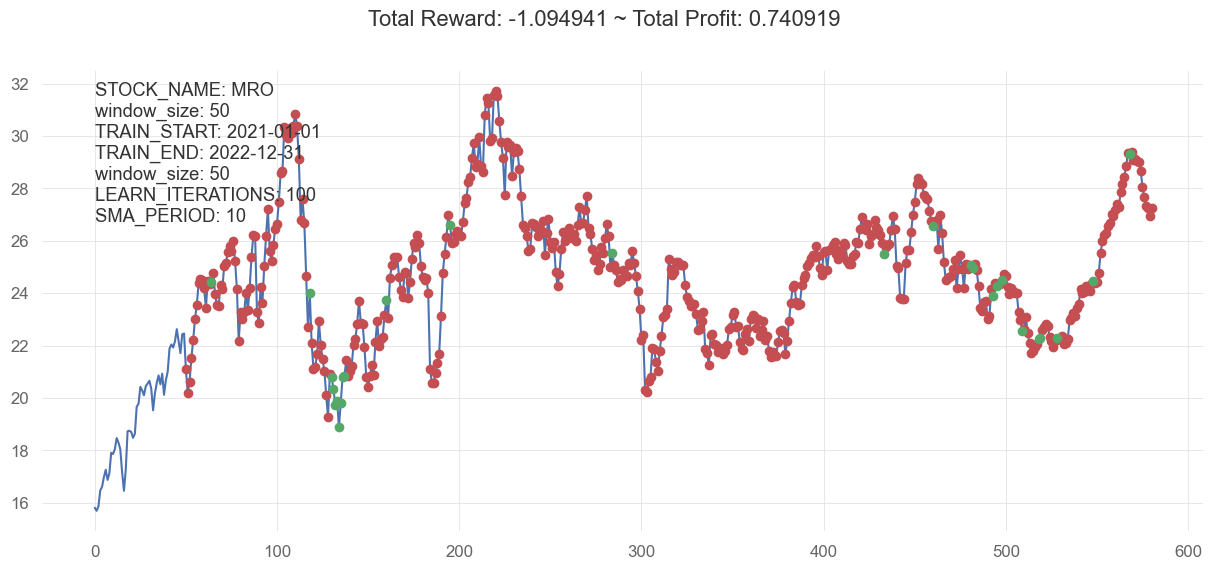

In [73]:
import os

stock_names = ['MCD', 'MRO', 'NLFX']
for stock_name in stock_names:

    # General settings
    base_settings = {
        'stock_name': stock_name,
        'train_start': '2021-01-01',
        'train_end': '2022-12-31',
        'learn_iteration': 100,
    }

    # Grid search
    grid = {
        'window_size': [10, 30, 50],
        'model_name': ['A2C', 'PPO', 'DQN']
    }

    if not os.path.exists(stock_name):
        os.makedirs(stock_name)

    # Loop over al grid search combinations
    for values in itertools.product(*grid.values()):
        point = dict(zip(grid.keys(), values))

        # merge the general settings
        settings = {**base_settings, **point}

        analyze_stock(**settings)